# Analyzis of the zero hit pages results
The dates used for tracking the zero hit queries were between 6th June to 8th June as the product's inverted index was created on 10th June.

The results shows that 50.8(~51%) of the instances are landing on zero hits even though the queries have greater than 35% match against the product index.

Of different possible reasons one could be the normalization part of the SEBE and hence this will influence our evaluation of the ML spellchecker in the online mode post BE integration. Therefore we have resorted to test the ML spellchecker against the existing SEBE spellchecker in a completely offline mode by calling the BE spellchecker API.


In [1]:
import os
os.environ.update({'MODIN_ENGINE': 'ray'}) # setting the compute engine for MODIN

In [2]:
import json
import datetime
import sys
import os
sys.path.append(os.path.join('..','src'))
from collections import defaultdict

import matplotlib.pyplot as plt 
import numpy as np
#import pandas as pd
import modin.pandas as pd
from google.cloud import bigquery
from tqdm.auto import tqdm

from utils import TextCleaner
from utils import take
from str_utils import has_digits

%load_ext autoreload
%autoreload 2

In [3]:

client = bigquery.Client(project='ecom-ai-poc')
textCleaner = TextCleaner()
tqdm.pandas(desc="Progress")

#### For windows users
* Install awk - https://stackoverflow.com/questions/21927944/how-to-run-an-awk-commands-in-windows
* Run - conda install posix

In [4]:
file_creation_date = !gsutil ls -l gs://search-ml-spellchecker/doc_counts.txt | awk '{print $2}' | head -1 | cut -d 'T' -f1
file_creation_date = file_creation_date[0].replace('-', '/')
file_creation_date

'2021/06/09'

In [5]:
datetime_ = datetime.datetime.strptime(file_creation_date, '%Y/%m/%d')
start_date = datetime_ + datetime.timedelta(days = -4)
start_date = start_date.date().strftime('%Y%m%d')

end_date = datetime_ + datetime.timedelta(days = -1)
end_date = end_date.date().strftime('%Y%m%d')
start_date, end_date

('20210605', '20210608')

In [6]:
# Downloading the data from the bucket which contains the terms with their frequency

# The doc_counts.txt file is a byproduct of generation of product index by the SEBE team
# for the use by DSC team.

# The file contains a token that appeared in the product index and its count accross different 
# fields in the index.
!gsutil cp gs://search-ml-spellchecker/doc_counts.txt .

In [7]:
# Loading the data from the file 
filename = 'doc_counts.txt'
words_counts = defaultdict(int)
with open(filename) as fh:
    for line in fh:
        command, count = line.strip().split(None, 1)
        words_counts[command] += int(count.strip())
take(5, words_counts)


Copying gs://search-ml-spellchecker/doc_counts.txt...
/ [0 files][    0.0 B/  6.6 MiB]                                                
/ [1 files][  6.6 MiB/  6.6 MiB]                                                

Operation completed over 1 objects/6.6 MiB.                                      


['aaa', 'aaaa', 'aaaaa', 'aaac', 'aaamicro']

In [8]:

# serialize the docs count
out_file = open("doc_counts.json", "w")
json.dump(words_counts, out_file, indent=2, sort_keys=False)
out_file.close()

words_counts['aaamicro']

8

In [9]:
# This sql script queries the search terms that led to zero hit
# on the date 2021-12-06 as the product index was created on 2021-12-10.
sql_query = f"""
SELECT search_keyword, SUM(CAST(custom_hit_count as NUMERIC)) as total_custom_hit_count, 
       SUM(product_count) as total_product_count
            FROM (

              SELECT DISTINCT c1.value as search_keyword, 
              c8.value as custom_hit_count, 
              COUNT(p.productSKU) as product_count

              FROM `valiant-metric-166707.36328697.ga_sessions_*` a,
              UNNEST(a.hits) b
              LEFT JOIN UNNEST(b.customDimensions) c1 ON (c1.index = 26)   #SearchKeyword
              LEFT JOIN UNNEST(b.customDimensions) c2 ON (c2.index = 5)    #Page Type
              LEFT JOIN UNNEST(b.customDimensions) c3 ON (c3.index = 91)   #FilterName
              LEFT JOIN UNNEST(b.customDimensions) c4 on (c4.index = 30)   #SortType
              LEFT JOIN UNNEST(b.customDimensions) c5 on (c5.index = 29)   #Pagenumber
              LEFT JOIN UNNEST(b.customDimensions) c6 on (c6.index = 28)   #SearchSuggest
              LEFT JOIN UNNEST(b.customDimensions) c7 on (c7.index = 3)    #Shop language the customer is using
              LEFT JOIN UNNEST(b.customDimensions) c8 on (c8.index = 25)   #Total number of search results
              LEFT JOIN UNNEST(b.product) p
              WHERE c1.value != ''                                   #Remove searches without searchterm
                  AND c2.value = 'Search Results'                    #Remove categorypage, brandpage etc.
                  AND c3.value IS NULL                               #Remove searches where a filter is applied
                  AND c5.value = '1'                                 #Limit to first page
                  AND (c6.value != 'category' OR c6.value IS NULL)   #Remove Categories from Suggest
                  AND (c7.value= 'de')
                  AND _TABLE_SUFFIX BETWEEN '{start_date}' AND '{end_date}'
              GROUP BY search_keyword, custom_hit_count
            )
            GROUP BY search_keyword
            HAVING total_custom_hit_count = 0 AND total_product_count = 0
"""
query_df = client.query(sql_query).result().to_dataframe()
query_df = query_df.astype({"total_custom_hit_count": int})
query_df.shape

(32168, 3)

In [10]:
# Normalizing, cleaning the data
query_df['clean_search_keyword'] = query_df['search_keyword'].progress_apply(
    lambda x: textCleaner.clean(x))
# filtering data with length more than 3 letters 
query_df = query_df[(query_df.clean_search_keyword.str.len() >= 3)]
query_df.shape


Progress: 100%|██████████| 32168/32168 [00:00<00:00, 45496.42it/s]


(26778, 4)

In [11]:
query_df.tail(5)

,search_keyword,total_custom_hit_count,total_product_count,clean_search_keyword
32163,golf 4 microschalter,0,0,golf 4 microschalter
32164,12v boilwe,0,0,12v boilwe
32165,adapter grafikarte msi 24 pol,0,0,adapter grafikarte msi 24 pol
32166,2x Molex Stecker auf PCI-E 8 pin,0,0,2x molex stecker auf pci e 8 pin
32167,nym 5x 4mm² 50m,0,0,nym 5x 4mm2 50m


### Checking whether we have any numbers in the product index

In [12]:
with open('doc_counts.json', 'r') as myfile:
    data = myfile.read()
words_counts_dict = json.loads(data)
inv_idx_check = list(map(has_digits, list(words_counts.keys())))

# removing any duplicates
set(inv_idx_check)

{False}

In [13]:
def query_match(search_query: list, words_counts: dict, threshold: int = 35):
    """
    Get the searched query and try to match it against
    the products inverted index.
    If the match is above the threshold, 
    then return 1 else 0
    Args:
        search_query (list(string)): Searched query
        terms_counts (dict): words count dictionary word -> count
    Returns:
        tuple: (matching_percentage, 1 or 0)
    """
    match_count = 0
    query_tokens = search_query.split(' ')
    query_len = len(query_tokens)
    for query_token in query_tokens:
        if words_counts.get(query_token):
            match_count += 1
    match_percent = (match_count / query_len) * 100
    if match_percent > threshold:
        return match_percent, 1
    else:
        return match_percent, 0

In [14]:
%time
query_df['match_percent'], query_df['match_found'] = \
    zip(*query_df['clean_search_keyword'].progress_apply(
        lambda x: query_match(x, words_counts=words_counts_dict)))

Wall time: 0 ns


Progress: 100%|██████████| 26778/26778 [00:00<00:00, 341324.06it/s]


In [15]:
def get_optimal_threshold(steps: int, words_counts: dict):
    """
    Create a list of various experiments for visualizing
     the matching percentage with the threshold

    Args:
        steps ([int]): steps that visualization with BE based on from 0 to 100
    """
    temp_threshold = []
    len_df = len(query_df)
    for step_thresh in range(0, 100, steps):
        query_df['match_percent'], query_df['match_found'] = \
            zip(*query_df['clean_search_keyword'].progress_apply(
                lambda x: query_match(x, words_counts_dict, threshold=step_thresh)))
        match_percentage = 100 * (len(query_df[query_df['match_found']==1]) / len_df)
        temp_threshold.append([step_thresh, match_percentage])
    return temp_threshold

In [16]:
thresh = get_optimal_threshold(15, words_counts=words_counts_dict)
labels, ys = zip(*thresh)
labels[:5], ys[:5]

Progress: 100%|██████████| 26778/26778 [00:00<00:00, 435272.38it/s]


((0, 15, 30, 45, 60),
 (64.41855254313242,
  64.22436328329225,
  59.67211890357756,
  47.184255732317574,
  30.61841810441407))

[[0, 64.41855254313242], [15, 64.22436328329225], [30, 59.67211890357756], [45, 47.184255732317574], [60, 30.61841810441407], [75, 15.281200985883936], [90, 12.536410486220031]]


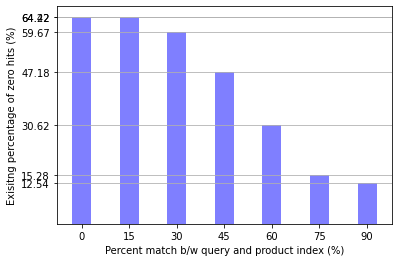

In [17]:
xs = np.arange(len(labels))
plt.bar(xs, ys, width = 0.4,
    color ='blue', align='center', alpha=0.5)
plt.xlabel('Percent match b/w query and product index (%)')
plt.ylabel('Exisitng percentage of zero hits (%)')
# Replace default x-ticks with xs, then replace xs with labels
plt.xticks(xs, labels)
plt.yticks(ys)
plt.grid(axis='y')
plt.show 
print(thresh)

### Inference
The sample below shows that the search query `standbohrmaschine alzmetall ab3es` even after having 
a 33% match against the product index results in the zero hit.

Conclusion from the graph above and the sample below:
Search queries with 45 to 60% match against the product index should 
not have resulted in zero hit which is not the case from the graph above.


The probable reason could be the normalization components of the SEBE. 
Because of this DSC team cannot opt for online A/B test as the performance of 
ml spellchecker will be influenced by various components of SEBE pipeline.


Solution - The DSC team will conduct an offline A/B test by taking the output
from ml spellchecker and output from correction phase of SEBE pipeline. 

In [35]:
test_sample_query = query_df[query_df['match_percent']>66].loc[32163]
test_sample_query

search_keyword            golf 4 microschalter
total_custom_hit_count                       0
total_product_count                          0
clean_search_keyword      golf 4 microschalter
match_percent                        66.666667
match_found                                  0
Name: 32163, dtype: object

In [36]:
query_df[query_df['clean_search_keyword'] == 'golf 4 microschalter']

,search_keyword,total_custom_hit_count,total_product_count,clean_search_keyword,match_percent,match_found
32163,golf 4 microschalter,0,0,golf 4 microschalter,66.666667,0
